# [7] 視界スコア指標 - Phase 5

ward座標データからグリッド特徴量を生成し、勝敗予測モデルを学習します。

## 処理フロー
1. **Task A**: グリッド特徴量生成（wards_matched.csv → ward_grid.npz）
2. **Task B**: データセット構築（ward_grid.npz + 勝敗ラベル → vision_dataset.npz）
3. **Task C**: 予測モデル学習（ロジスティック回帰 / CNN）
4. **Task D**: ヒートマップ可視化

## 前提条件
- **06_ward_batch_processing.ipynb 完了**（wards_matched.csvが各試合フォルダに存在）
- タイムラインデータ（data/timeline/*.json）

In [1]:
#cell-1: ライブラリインポート
from pathlib import Path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

load_dotenv("../RiotAPI.env")
API_KEY = os.environ.get("API_KEY")

PROJECT_ROOT = Path(r"c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2")

# autoLeagueモジュール
import sys
sys.path.insert(0, str(PROJECT_ROOT))

from autoLeague.scoring import (
    DatasetBuilder,
    build_dataset,
    VisionPredictor,
    load_dataset,
    visualize_importance_heatmap,
    visualize_importance_grid,
    visualize_top_cells,
    print_importance_summary,
)

In [2]:
#cell-2: パス設定

# 入力データ
DATASET_DIR = Path(r"C:\dataset_20260105")  # ミニマップキャプチャ + wards_matched.csv
TIMELINE_DIR = PROJECT_ROOT / "data" / "timeline"  # タイムラインJSON
MATCH_DIR = PROJECT_ROOT / "data" / "match"
DATASET_PATH = PROJECT_ROOT / "data" / "vision_dataset.npz"

# 出力
OUTPUT_DATASET = PROJECT_ROOT / "data" / "vision_dataset.npz"
OUTPUT_MODEL_DIR = PROJECT_ROOT / "models"
OUTPUT_HEATMAP_DIR = PROJECT_ROOT / "heatmaps"

# 確認
print(f"データセットディレクトリ: {DATASET_DIR}")
print(f"  存在: {DATASET_DIR.exists()}")

if DATASET_DIR.exists():
    match_dirs = sorted(DATASET_DIR.glob("JP1-*"))
    print(f"  試合数: {len(match_dirs)}")

print(f"\nタイムラインディレクトリ: {TIMELINE_DIR}")
print(f"  存在: {TIMELINE_DIR.exists()}")

if TIMELINE_DIR.exists():
    timeline_files = list(TIMELINE_DIR.glob("JP1_*.json"))
    print(f"  ファイル数: {len(timeline_files)}")

データセットディレクトリ: C:\dataset_20260105
  存在: True
  試合数: 123

タイムラインディレクトリ: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\data\timeline
  存在: True
  ファイル数: 190


## Task A + B: データセット構築

各試合の`wards_matched.csv`からグリッド特徴量を生成し、勝敗ラベルを付与して統合データセットを作成します。

In [3]:
#cell-3: wards_matched.csvの確認

# 最初の試合のwards_matched.csvを確認
if DATASET_DIR.exists():
    match_dirs = sorted(DATASET_DIR.glob("JP1-*"))
    if match_dirs:
        sample_csv = match_dirs[0] / "wards_matched.csv"
        if sample_csv.exists():
            df = pd.read_csv(sample_csv)
            print(f"サンプル: {sample_csv}")
            print(f"レコード数: {len(df)}")
            print(f"\nカラム: {list(df.columns)}")
            print(f"\n先頭5行:")
            display(df.head())
        else:
            print(f"wards_matched.csvが見つかりません: {sample_csv}")

サンプル: C:\dataset_20260105\JP1-555620750\wards_matched.csv
レコード数: 130

カラム: ['ward_id', 'timeline_ward_id', 'class_name', 'ward_type', 'team', 'x_pixel', 'y_pixel', 'x_normalized', 'y_normalized', 'frame_start', 'frame_end', 'confidence_avg', 'creator_id', 'timestamp_placed', 'timestamp_killed', 'match_status']

先頭5行:


,ward_id,timeline_ward_id,class_name,ward_type,team,x_pixel,y_pixel,x_normalized,y_normalized,frame_start,frame_end,confidence_avg,creator_id,timestamp_placed,timestamp_killed,match_status
0,1,1.0,stealth_ward_enemy,YELLOW_TRINKET,red,223.0,215.0,0.435593,0.421398,18,120.0,0.9304,7.0,29293,NaN,matched
1,2,2.0,stealth_ward,YELLOW_TRINKET,blue,461.0,423.0,0.901556,0.827569,39,44.0,0.9048,5.0,46127,NaN,matched
2,3,3.0,stealth_ward_enemy,YELLOW_TRINKET,red,69.0,209.0,0.136065,0.408585,151,246.0,0.9057,6.0,144339,245813.0,matched
3,4,4.0,stealth_ward_enemy,YELLOW_TRINKET,red,219.0,224.0,0.428947,0.438883,154,251.0,0.8648,8.0,148694,245813.0,matched
4,5,5.0,stealth_ward,YELLOW_TRINKET,blue,113.0,119.0,0.222639,0.233715,187,256.0,0.9016,1.0,180548,245813.0,matched


In [4]:
#cell-4: データセット構築（Task A + B）

# DatasetBuilderを使用
builder = DatasetBuilder(
    dataset_dir=DATASET_DIR,
    match_dir=MATCH_DIR,
    output_path=DATASET_PATH,
    api_key=API_KEY,  # Riot APIキー（不足分のマッチJSONを自動取得）
)

# データセットを構築・保存
print("データセット構築開始...")
builder.build()

# 保存されたデータセットを読み込み
from autoLeague.scoring.dataset_builder import load_dataset
X, y, match_ids = load_dataset(DATASET_PATH)

print(f"\n=== データセット情報 ===")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"試合数: {len(match_ids)}")
print(f"Blue勝利: {y.sum()}, Red勝利: {len(y) - y.sum()}")

データセット構築開始...
全123試合を処理します
データセット: C:\dataset_20260105
マッチJSON: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\data\match
出力先: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\data\vision_dataset.npz
APIキー: 設定済み（不足分は自動取得）

処理中: JP1-555620750... マッチJSON取得中...   取得完了: JP1_555620750
OK (勝者: blue)
処理中: JP1-555621265... OK (勝者: blue)
処理中: JP1-555622520... マッチJSON取得中...   取得完了: JP1_555622520
OK (勝者: red)
処理中: JP1-555625059... マッチJSON取得中...   取得完了: JP1_555625059
OK (勝者: red)
処理中: JP1-555625212... マッチJSON取得中...   取得完了: JP1_555625212
OK (勝者: blue)
処理中: JP1-555625930... マッチJSON取得中...   取得完了: JP1_555625930
OK (勝者: red)
処理中: JP1-555626699... マッチJSON取得中...   取得完了: JP1_555626699
OK (勝者: red)
処理中: JP1-555626898... マッチJSON取得中...   取得完了: JP1_555626898
OK (勝者: blue)
処理中: JP1-555629794... マッチJSON取得中...   取得完了: JP1_555629794
OK (勝者: blue)
処理中: JP1-555631605... マッチJSON取得中...   取得完了: JP1_555631605
OK (勝者: red)
処理中: JP1-555634259... マッチJSON取得中...   取得完了: JP1_555634259
OK (勝者: red)
処

In [5]:
#cell-5: データセット保存

# 出力ディレクトリ作成
OUTPUT_DATASET.parent.mkdir(parents=True, exist_ok=True)

# 保存
np.savez(
    OUTPUT_DATASET,
    X=X,
    y=y,
    match_ids=np.array(match_ids, dtype=object)
)

print(f"データセット保存完了: {OUTPUT_DATASET}")
print(f"ファイルサイズ: {OUTPUT_DATASET.stat().st_size / 1024:.1f} KB")

データセット保存完了: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\data\vision_dataset.npz
ファイルサイズ: 2964.4 KB


## Task C: 予測モデル学習

グリッド特徴量から勝敗を予測するモデルを学習します。

### モデル選択肢
1. **ロジスティック回帰**（推奨）: シンプルで解釈しやすい
2. **浅いCNN**: 空間パターンを学習可能

In [6]:
#cell-6: データセット読み込み（既存データを使用する場合）

# 既にvision_dataset.npzがある場合はここから開始可能
if OUTPUT_DATASET.exists():
    X, y, match_ids = load_dataset(OUTPUT_DATASET)
    print(f"データセット読み込み完了")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Blue勝利: {y.sum()}, Red勝利: {len(y) - y.sum()}")
else:
    print(f"データセットが見つかりません: {OUTPUT_DATASET}")
    print("cell-4, cell-5を先に実行してください")

データセット読み込み完了
X shape: (123, 2, 3, 32, 32)
y shape: (123,)
Blue勝利: 60, Red勝利: 63


In [7]:
#cell-7: Train/Test分割

from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
RANDOM_STATE = 42

try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=y
    )
except ValueError:
    # サンプル数が少ない場合は層化なし
    print("警告: サンプル数が少ないため層化抽出を無効化")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
    )

print(f"学習データ: {len(X_train)}件")
print(f"テストデータ: {len(X_test)}件")

学習データ: 98件
テストデータ: 25件


In [8]:
#cell-8: ロジスティック回帰モデルの学習

# モデル作成
predictor_lr = VisionPredictor(model_type="logistic")

# 学習
print("ロジスティック回帰モデル学習中...")
metrics_lr = predictor_lr.fit(X_train, y_train, verbose=True)

print(f"\n学習完了")
print(f"Train accuracy: {metrics_lr['train_accuracy']:.3f}")

ロジスティック回帰モデル学習中...
Train accuracy: 1.000

学習完了
Train accuracy: 1.000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [9]:
#cell-9: ロジスティック回帰モデルの評価

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 予測
y_pred_lr = predictor_lr.predict(X_test)

# 評価
print("=== ロジスティック回帰 評価結果 ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_lr, zero_division=0):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr, zero_division=0):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_lr, zero_division=0):.3f}")

# 混同行列
cm = confusion_matrix(y_test, y_pred_lr)
print(f"\n混同行列:")
print(f"(予測→)   Red  Blue")
print(f"実際Red   {cm[0][0]:4d}  {cm[0][1]:4d}")
print(f"実際Blue  {cm[1][0]:4d}  {cm[1][1]:4d}")

=== ロジスティック回帰 評価結果 ===
Accuracy:  0.640
Precision: 0.600
Recall:    0.750
F1 Score:  0.667

混同行列:
(予測→)   Red  Blue
実際Red      7     6
実際Blue     3     9


In [10]:
#cell-10: CNNモデルの学習（オプション）

# CNNモデル作成
predictor_cnn = VisionPredictor(model_type="cnn")

# 学習
print("CNNモデル学習中...")
metrics_cnn = predictor_cnn.fit(X_train, y_train, epochs=100, verbose=True)

# 予測
y_pred_cnn = predictor_cnn.predict(X_test)

# 評価
print("\n=== CNN 評価結果 ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_cnn):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_cnn, zero_division=0):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_cnn, zero_division=0):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_cnn, zero_division=0):.3f}")

CNNモデル学習中...
Epoch 10/100, Loss: 0.6366
Epoch 20/100, Loss: 0.5575
Epoch 30/100, Loss: 0.4928
Epoch 40/100, Loss: 0.5161
Epoch 50/100, Loss: 0.5177
Epoch 60/100, Loss: 0.3930
Early stopping at epoch 65
Train accuracy: 0.918

=== CNN 評価結果 ===
Accuracy:  0.680
Precision: 0.643
Recall:    0.750
F1 Score:  0.692


In [11]:
#cell-11: モデル比較

print("=== モデル比較 ===")
print(f"{'モデル':<20} {'Accuracy':<12} {'F1 Score':<12}")
print("-" * 44)
print(f"{'ロジスティック回帰':<20} {accuracy_score(y_test, y_pred_lr):<12.3f} {f1_score(y_test, y_pred_lr, zero_division=0):<12.3f}")
print(f"{'CNN':<20} {accuracy_score(y_test, y_pred_cnn):<12.3f} {f1_score(y_test, y_pred_cnn, zero_division=0):<12.3f}")
print(f"{'ベースライン(ランダム)':<20} {'0.500':<12} {'-':<12}")

# 推奨モデル選択
if accuracy_score(y_test, y_pred_lr) >= accuracy_score(y_test, y_pred_cnn):
    best_model = "logistic"
    best_predictor = predictor_lr
else:
    best_model = "cnn"
    best_predictor = predictor_cnn

print(f"\n推奨モデル: {best_model}")

=== モデル比較 ===
モデル                  Accuracy     F1 Score    
--------------------------------------------
ロジスティック回帰            0.640        0.667       
CNN                  0.680        0.692       
ベースライン(ランダム)         0.500        -           

推奨モデル: cnn


In [12]:
#cell-12: モデル保存

OUTPUT_MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ロジスティック回帰モデル保存
lr_path = OUTPUT_MODEL_DIR / "vision_predictor.joblib"
predictor_lr.save(lr_path)
print(f"ロジスティック回帰モデル保存: {lr_path}")

# CNNモデル保存
cnn_path = OUTPUT_MODEL_DIR / "vision_predictor.pt"
predictor_cnn.save(cnn_path)
print(f"CNNモデル保存: {cnn_path}")

# メトリクス保存
metrics_path = OUTPUT_MODEL_DIR / "vision_predictor_metrics.json"
metrics = {
    "model_type": best_model,
    "n_samples_train": len(X_train),
    "n_samples_test": len(X_test),
    "test_accuracy": float(accuracy_score(y_test, y_pred_lr if best_model == "logistic" else y_pred_cnn)),
    "test_precision": float(precision_score(y_test, y_pred_lr if best_model == "logistic" else y_pred_cnn, zero_division=0)),
    "test_recall": float(recall_score(y_test, y_pred_lr if best_model == "logistic" else y_pred_cnn, zero_division=0)),
    "test_f1": float(f1_score(y_test, y_pred_lr if best_model == "logistic" else y_pred_cnn, zero_division=0)),
}
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)
print(f"メトリクス保存: {metrics_path}")

ロジスティック回帰モデル保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\vision_predictor.joblib
CNNモデル保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\vision_predictor.pt
メトリクス保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\vision_predictor_metrics.json


## Task D: ヒートマップ可視化

特徴量重要度をヒートマップとして可視化し、「どの座標・時間帯のward配置が勝敗に影響するか」を分析します。

In [13]:
#cell-13: 特徴量重要度取得

# ロジスティック回帰の重要度を使用（解釈しやすい）
importance = predictor_lr.get_feature_importance()

print(f"特徴量重要度")
print(f"  形状: {importance.shape}")
print(f"  値域: [{importance.min():.4f}, {importance.max():.4f}]")

# 統計情報表示
print_importance_summary(importance)

特徴量重要度
  形状: (3, 32, 32)
  値域: [-0.0774, 0.0781]

=== Feature Importance Summary ===
Shape: (3, 32, 32)
Overall range: [-0.0774, 0.0781]

Phase 1: 0-10min (Early):
  Range: [-0.0774, 0.0733]
  Mean:  0.0008
  Std:   0.0135
  Top Blue advantage: cell (np.int64(11), np.int64(17)) = 0.0733
  Top Red advantage:  cell (np.int64(19), np.int64(18)) = -0.0774

Phase 2: 10-20min (Mid):
  Range: [-0.0720, 0.0781]
  Mean:  0.0014
  Std:   0.0163
  Top Blue advantage: cell (np.int64(14), np.int64(1)) = 0.0781
  Top Red advantage:  cell (np.int64(21), np.int64(22)) = -0.0720

Phase 3: 20min+ (Late):
  Range: [-0.0513, 0.0736]
  Mean:  0.0011
  Std:   0.0130
  Top Blue advantage: cell (np.int64(19), np.int64(21)) = 0.0736
  Top Red advantage:  cell (np.int64(17), np.int64(20)) = -0.0513



In [14]:
#cell-14: 特徴量重要度保存

importance_path = OUTPUT_MODEL_DIR / "vision_importance.npy"
np.save(importance_path, importance)
print(f"特徴量重要度保存: {importance_path}")

特徴量重要度保存: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\vision_importance.npy


In [15]:
#cell-15: 時間帯別ヒートマップ生成

OUTPUT_HEATMAP_DIR.mkdir(parents=True, exist_ok=True)

# ヒートマップ生成
output_files = visualize_importance_heatmap(
    importance=importance,
    output_dir=OUTPUT_HEATMAP_DIR,
)

print(f"生成されたファイル:")
for f in output_files:
    print(f"  {f}")

生成されたファイル:
  c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\heatmaps\importance_phase0.png
  c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\heatmaps\importance_phase1.png
  c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\heatmaps\importance_phase2.png
  c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\heatmaps\importance_combined.png


c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\autoLeague\scoring\visualizer.py:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


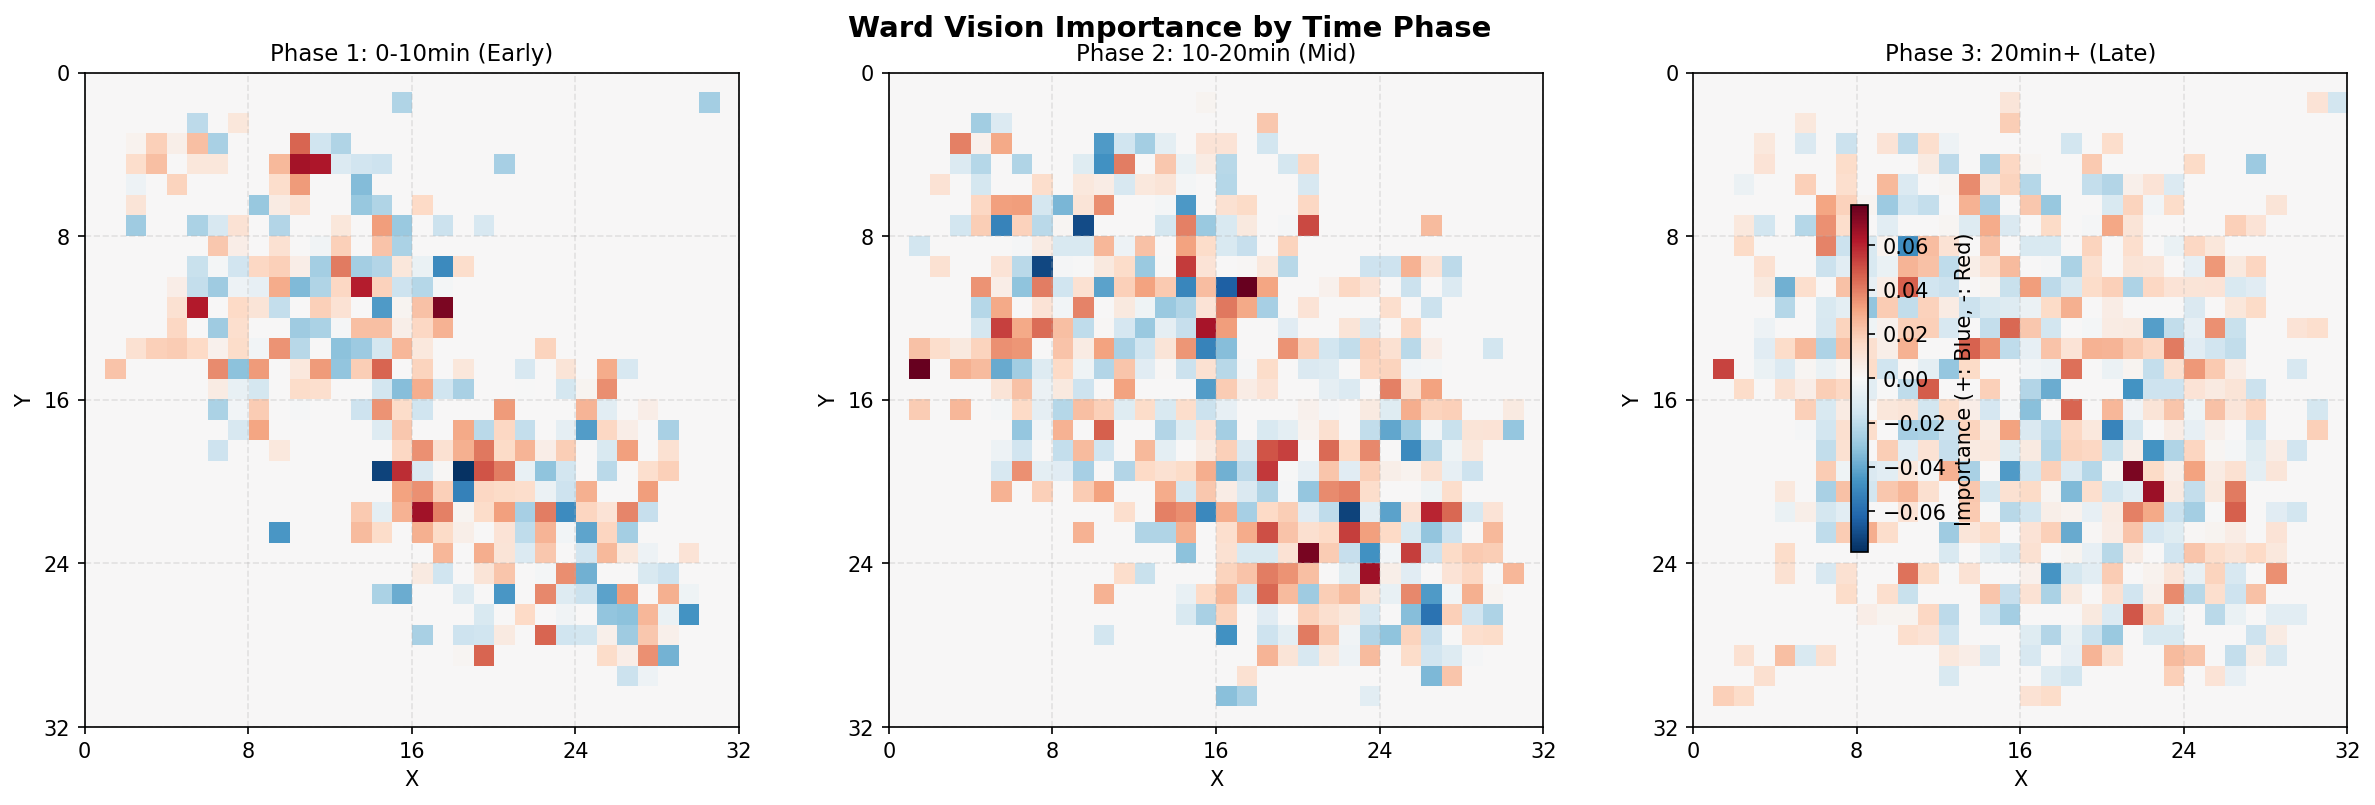

In [16]:
#cell-16: グリッド表示（3時間帯並列）

grid_path = visualize_importance_grid(
    importance=importance,
    output_path=OUTPUT_HEATMAP_DIR / "importance_grid.png",
)

# 表示
from IPython.display import Image, display
display(Image(filename=str(grid_path), width=900))

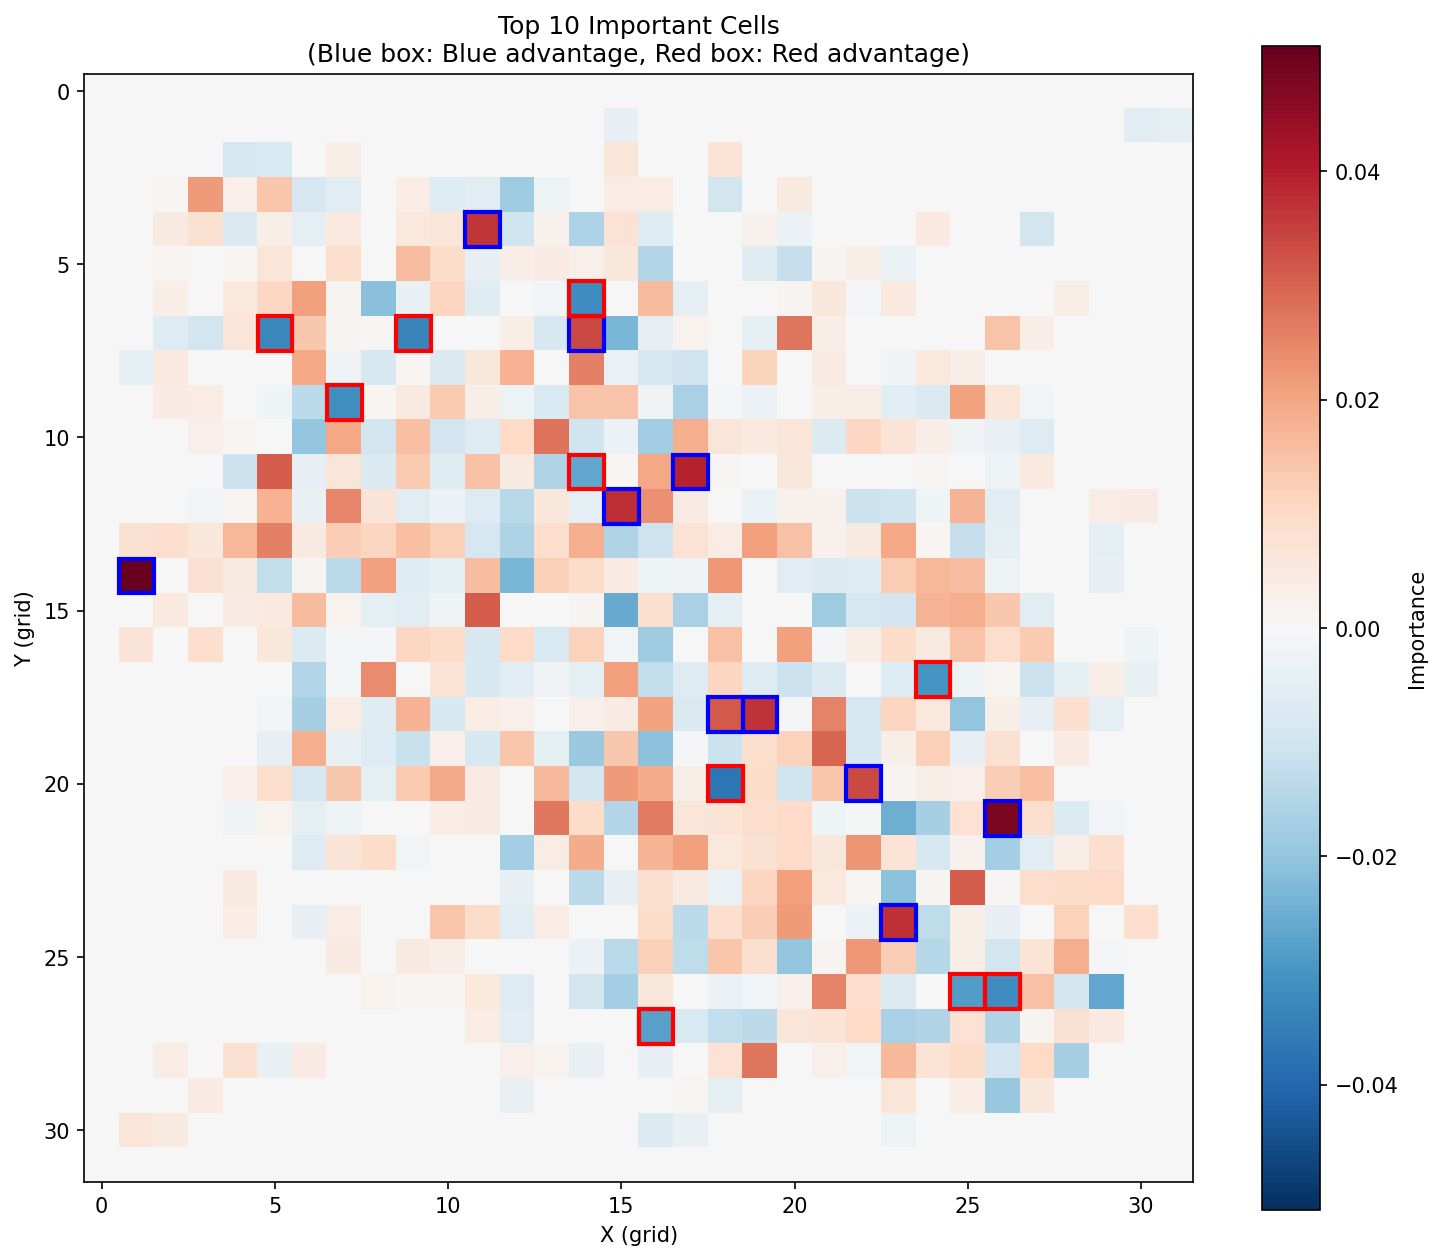

In [17]:
#cell-17: 上位セルハイライト表示

top_cells_path = visualize_top_cells(
    importance=importance,
    output_path=OUTPUT_HEATMAP_DIR / "importance_top_cells.png",
    top_n=10,
)

# 表示
display(Image(filename=str(top_cells_path), width=600))

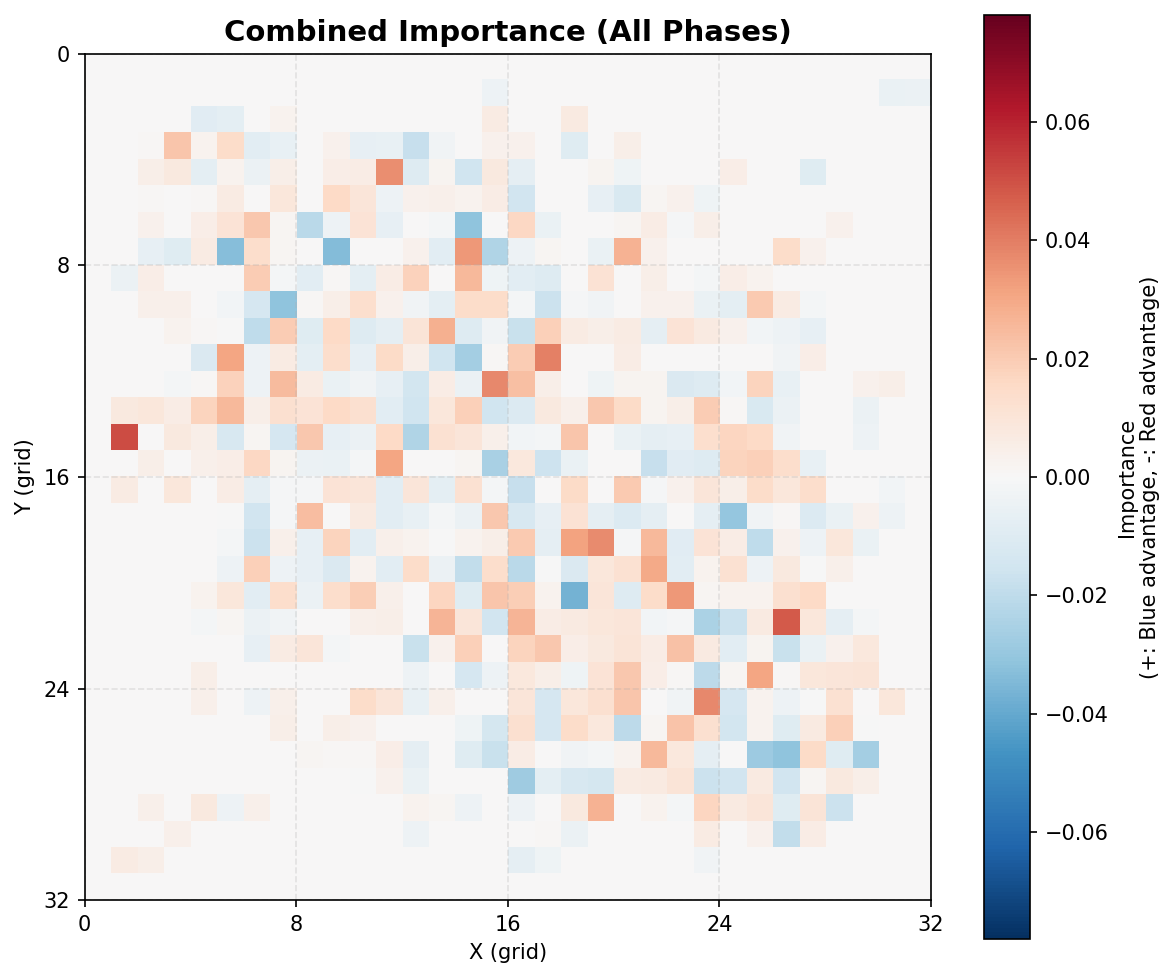

In [18]:
#cell-18: 統合ヒートマップ表示

combined_path = OUTPUT_HEATMAP_DIR / "importance_combined.png"
if combined_path.exists():
    display(Image(filename=str(combined_path), width=600))

## 結果サマリー

In [20]:
#cell-19: 結果サマリー

print("=" * 60)
print("Phase 5 視界スコア指標 - 完了")
print("=" * 60)

print(f"\n【データセット】")
print(f"  試合数: {len(match_ids)}")
print(f"  入力形状: {X.shape}")
print(f"  Blue勝利: {y.sum()}, Red勝利: {len(y) - y.sum()}")

print(f"\n【モデル性能】")
print(f"  推奨モデル: {best_model}")
print(f"  Test Accuracy: {metrics['test_accuracy']:.1%}")
print(f"  Test F1 Score: {metrics['test_f1']:.1%}")
print(f"  ベースライン改善: +{(metrics['test_accuracy'] - 0.5) / 0.5 * 100:.1f}%")

print(f"\n【出力ファイル】")
print(f"  データセット: {OUTPUT_DATASET}")
print(f"  モデル: {lr_path}")
print(f"  メトリクス: {metrics_path}")
print(f"  ヒートマップ: {OUTPUT_HEATMAP_DIR}/")

print(f"\n【主要な知見】")
phase_totals = [np.abs(importance[i]).sum() for i in range(3)]
most_important_phase = np.argmax(phase_totals)
phase_names = ["Phase 1 (0-10min)", "Phase 2 (10-20min)", "Phase 3 (20min+)"]
print(f"  最重要時間帯: {phase_names[most_important_phase]}")

Phase 5 視界スコア指標 - 完了

【データセット】
  試合数: 123
  入力形状: (123, 2, 3, 32, 32)
  Blue勝利: 60, Red勝利: 63

【モデル性能】
  推奨モデル: cnn
  Test Accuracy: 68.0%
  Test F1 Score: 69.2%
  ベースライン改善: +36.0%

【出力ファイル】
  データセット: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\data\vision_dataset.npz
  モデル: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\vision_predictor.joblib
  メトリクス: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\models\vision_predictor_metrics.json
  ヒートマップ: c:\Users\lapis\Desktop\LoL_WorkSp_win\pyLoL-_WorkSp\pyLoL-v2\heatmaps/

【主要な知見】
  最重要時間帯: Phase 2 (10-20min)
